<a href="https://colab.research.google.com/github/C242-PS091-Capstone-Bangkit/ML-Project/blob/main/SkinCondition/Skin_Condition_Model_InceptionV3_With_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2: Using CNN's with the Skin Condition Dataset

For the first model we will use the `skin condition` dataset to train a model that can classify 5 skin condition. For this, we will create own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities. In addition, we also tried the pre-trained model from InceptionV3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Required Libraries

Before we proceed with dataset, let's first install the required libraries to ensure everything is set up correctly for the next steps.

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files

Since we have already installed the required libraries, we can now proceed to the next step, which is **Pre-Processing the Dataset**.

<a name="2"></a>
## Pre-Processing the Dataset

Let's explore the dataset in the folder `./SkinCondition`. There is a subdirectory for each skin condition class, which consists of images representing various conditions, namely acne, dark spots, large pores, normal skin, and wrinkles. The complete directory tree looks like this:

```
.
└── SkinCondition/
    ├── acne/
    │   ├── acne_1.jpg
    │   ├── acne_2.jpg
    │   └── ...
    └── dark spot/
        ├── darkspot_1.jpg
        ├── darkspot_2.jpg
    |   └── ...
    └── large pores/
        ├── largepores_1.jpg
        ├── largepores_2.jpg
    |   └── ...
    └── normal/
        ├── normal_1.jpg
        ├── normal_2.jpg
    |   └── ...
    └── wrinkles/
        ├── wrinkles_1.jpg
        ├── wrinkles_2.jpg
        └── ...

```

### Load Image

Before we begin building the model, let's load an image to explore it's content and understand it's properties. This will help us get a clearer idea of the data we're working with and ensure that we can process the images correctly for the next steps.

In [ ]:
DATA_DIR = '/content/drive/My Drive/Skin Condition/SkinCondition'

data_dir_acne = os.path.join(DATA_DIR, 'acne')
data_dir_darkspot = os.path.join(DATA_DIR, 'dark spot')
data_dir_largepores = os.path.join(DATA_DIR, 'large pores')
data_dir_wrinkles = os.path.join(DATA_DIR, 'wrinkles')
data_dir_normal = os.path.join(DATA_DIR, 'normal')

print(f"There are {len(os.listdir(data_dir_acne))} images of acne.")
print(f"There are {len(os.listdir(data_dir_darkspot))} images of dark spot.")
print(f"There are {len(os.listdir(data_dir_largepores))} images of large pores.")
print(f"There are {len(os.listdir(data_dir_wrinkles))} images of wrinkles.")
print(f"There are {len(os.listdir(data_dir_normal))} images of normal.")

There are 420 images of acne.
There are 430 images of dark spot.
There are 420 images of large pores.
There are 420 images of wrinkles.
There are 420 images of normal.


While it's useful to know the number of images in each class, let's visualize a few of them to gain a clearer understanding of the types of images in the dataset:

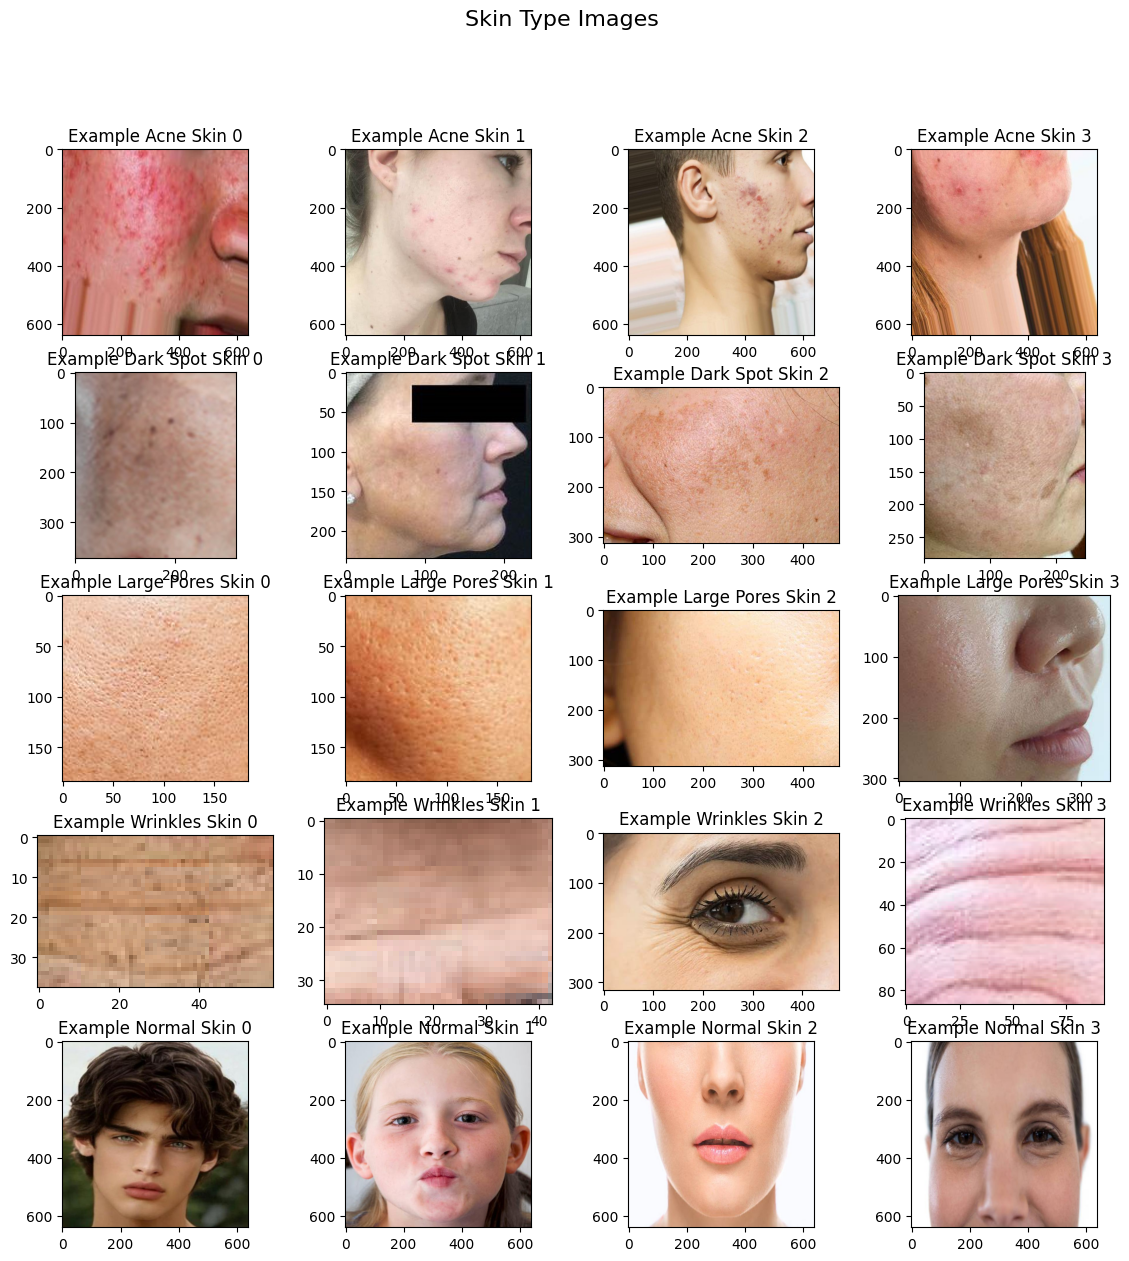

In [ ]:
acne_filenames = [os.path.join(data_dir_acne, filename) for filename in os.listdir(data_dir_acne)]
darkspot_filenames = [os.path.join(data_dir_darkspot, filename) for filename in os.listdir(data_dir_darkspot)]
largepores_filenames = [os.path.join(data_dir_largepores, filename) for filename in os.listdir(data_dir_largepores)]
wrinkles_filenames = [os.path.join(data_dir_wrinkles, filename) for filename in os.listdir(data_dir_wrinkles)]
normal_filenames = [os.path.join(data_dir_normal, filename) for filename in os.listdir(data_dir_normal)]

num_examples = 4

random_acne = random.sample(acne_filenames, num_examples)
random_darkspot = random.sample(darkspot_filenames, num_examples)
random_largepores = random.sample(largepores_filenames, num_examples)
random_wrinkles = random.sample(wrinkles_filenames, num_examples)
random_normal = random.sample(normal_filenames, num_examples)

fig, axes = plt.subplots(5, num_examples, figsize=(14, 14))
fig.suptitle('Skin Type Images', fontsize=16)

for i, acne_image in enumerate(random_acne):
    img = tf.keras.utils.load_img(acne_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Acne Skin {i}')

for i, darkspot_image in enumerate(random_darkspot):
    img = tf.keras.utils.load_img(darkspot_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dark Spot Skin {i}')

for i, largepores_image in enumerate(random_largepores):
    img = tf.keras.utils.load_img(largepores_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Large Pores Skin {i}')

for i, wrinkles_image in enumerate(random_wrinkles):
    img = tf.keras.utils.load_img(wrinkles_image)
    axes[3, i].imshow(img)
    axes[3, i].set_title(f'Example Wrinkles Skin {i}')

for i, normal_image in enumerate(random_normal):
    img = tf.keras.utils.load_img(normal_image)
    axes[4, i].imshow(img)
    axes[4, i].set_title(f'Example Normal Skin {i}')
plt.show()

These example images from each skin condition class are certainly interesting! Notice that these images come in all kinds of resolutions!

### Split Dataset

Once we have loaded the images, the next step is to split the dataset into training and validation sets. This split ensures that we can train our model on one portion of the data while using another portion to evaluate its performance.

In [ ]:
def train_val_datasets():
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory= DATA_DIR,
        image_size=(224, 224),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='both',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
training_dataset, validation_dataset = train_val_datasets()

Found 2077 files belonging to 5 classes.
Using 1662 files for training.
Using 415 files for validation.


At this point, we now have two separate datasets, one dedicated to training the model and the other for validating its performance.

The training dataset will be used to teach the model to recognize patterns and make predictions, while the validation dataset will allow we to assess how well the model generalizes to new, unseen data, helping to fine-tune the model and avoid overfitting.

In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 224, 224, 3)
Shape of batch of labels: (128, 5)


Keep in mind that the pixel values of the images are not normalized yet, so we need to add a Rescaling layer in the model to scale these values by a factor of 1./255.

### Data Augmentation

With the data in the approciate format, the next step is to apply data augmentation to enhance the model's robustness by creating varied image versions through transformations such as rotation, flipping, scaling, or color adjustments.

In [ ]:
def create_augmentation_model():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
    ])

augmentation_model = create_augmentation_model()
train_dataset = training_dataset.map(lambda x, y: (augmentation_model(x), y))

In [ ]:
def demo_augmentation(sample_image, model, num_aug):

    image_preview = []

    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    image_preview.append(sample_image_pil)

    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

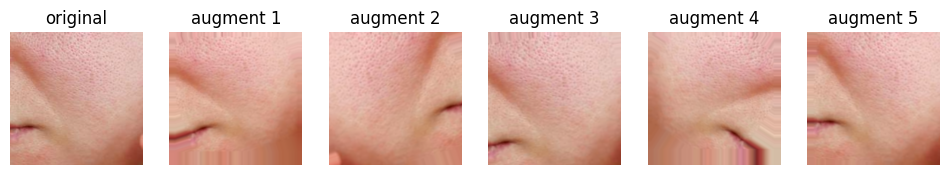

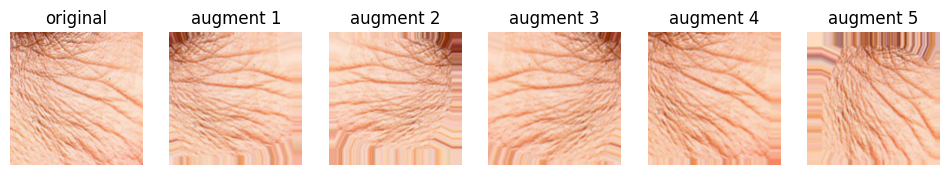

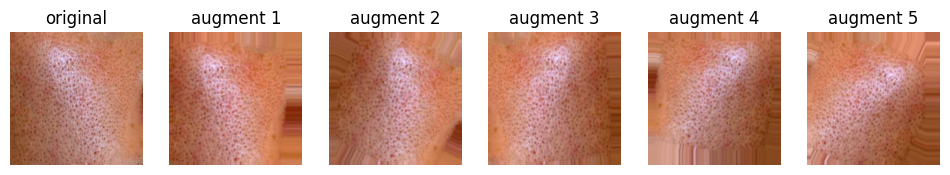

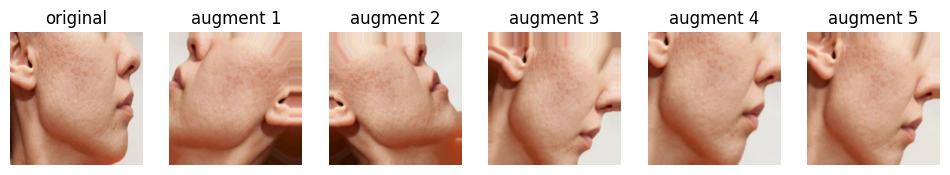

In [ ]:
NUM_AUG = 5

sample_batch = list(training_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[1], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[2], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[3], create_augmentation_model(), NUM_AUG)

del sample_batch

Now that we have applied data augmentation, the datasets with varied image versions are ready, and we can proceed to the next step, which is **Build and Train The Model**.

## Build and Train The Model

After completing the pre-processing steps, we will proceed by building the model using pre-trained model from InceptionV3 and perform fine-tuning starting from layer 150 to adapt the model to our specific dataset.

In [ ]:
def create_transfer_learning_model():
    base_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    fine_tune_at = 150
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

The next cell allows us to examine the total number of parameters in the model.

In [ ]:
model = create_transfer_learning_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,701 (84.17 MB)

 Trainable params: 17,629,893 (67.25 MB)

 Non-trainable params: 4,435,808 (16.92 MB)

Now, we can begin training the model. We will use 100 epochs for the training process.

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 332s 26s/step - accuracy: 0.4906 - loss: 3.6819 - val_accuracy: 0.6096 - val_loss: 3.4494
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.6909 - loss: 3.1866 - val_accuracy: 0.7205 - val_loss: 3.1208
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.7785 - loss: 2.9405 - val_accuracy: 0.7373 - val_loss: 3.0682
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8673 - loss: 2.6969 - val_accuracy: 0.7639 - val_loss: 3.0242
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8871 - loss: 2.5902 - val_accuracy: 0.7783 - val_loss: 2.9059
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9045 - loss: 2.4993 - val_accuracy: 0.8169 - val_loss: 2.7823
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9279 - loss: 2.3794 - val_accuracy: 0.8289 - val_loss: 2.6912
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9488 - loss: 2.3011 - val_accuracy: 0.8843 -

The following code will display the training and validation accuracy achieved at the end of each epoch once the training is complete.

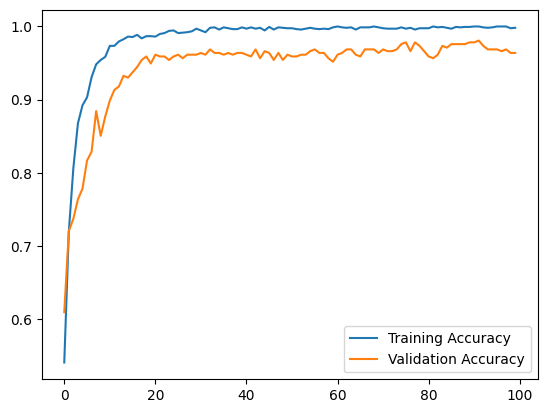

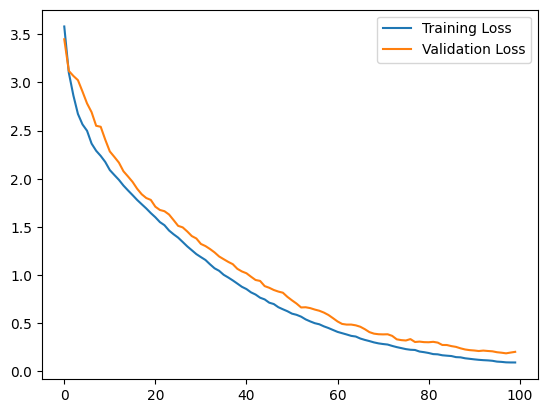

In [ ]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Now that we have successfully built and trained the model using the prepared dataset to achieve high accuracy, we can proceed to the next step, which is **Evaluate the Model**.

## Evaluate the Model

After training the model, we evaluate its performance using the confusion matrix. We can also view the Classification Report, which includes precision, recall, f1-score, and support for each class.

But, before creating the confusion matrix, we need to ensure that the labels are correctly assigned and match the predicted values with the actual ones.

In [ ]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
print(dataset.class_to_idx)

{'acne': 0, 'dark spot': 1, 'large pores': 2, 'normal': 3, 'wrinkles': 4}


After ensuring the labels are correctly assigned, we can run the following code to evaluate the model using the confusion matrix.

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step


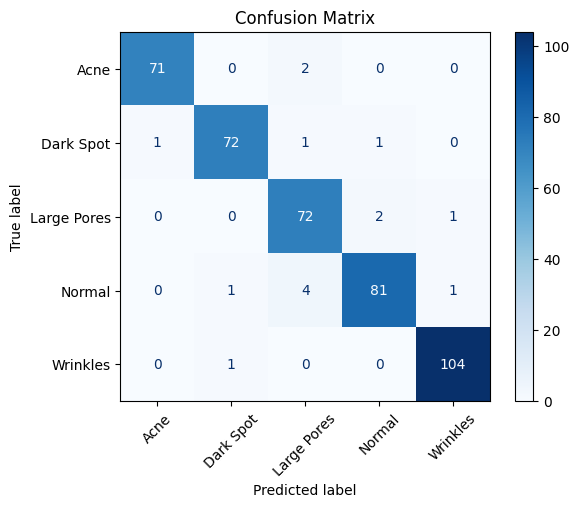

Classification Report:
              precision    recall  f1-score   support

        Acne       0.99      0.97      0.98        73
   Dark Spot       0.97      0.96      0.97        75
 Large Pores       0.91      0.96      0.94        75
      Normal       0.96      0.93      0.95        87
    Wrinkles       0.98      0.99      0.99       105

    accuracy                           0.96       415
   macro avg       0.96      0.96      0.96       415
weighted avg       0.96      0.96      0.96       415

Accuracy: 0.96


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_class, y_pred_class)

class_labels = ['Acne', 'Dark Spot', 'Large Pores', 'Normal', 'Wrinkles']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true_class, y_pred_class)

print("Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=class_labels))
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary, average='macro')
recall = recall_score(y_true, y_pred_binary, average='macro')
f1 = f1_score(y_true, y_pred_binary, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9614
Precision: 0.9658
Recall: 0.9601
F1 Score: 0.9627


After achieving satisfactory performance in classifying each skin condition class, we can move to the next step, which is **Test the Model** on an unseen dataset.

## Test the Model


After successfully building the model and achieving good performance when evaluating it with a confusion matrix, we can proceed to test the model using previously unseen data to measure its performance and generalization.

Upload an image after running the following code and observe the classification results with confidence values.

Saving berjerawat (209).jpg to berjerawat (209) (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


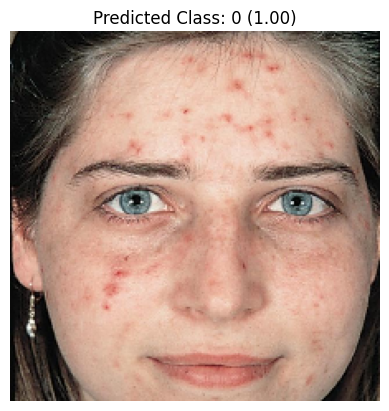

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving ds.jpg to ds (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


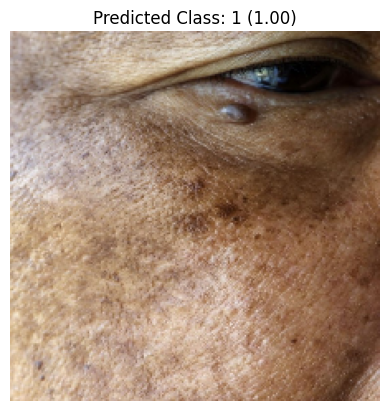

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving OIP - 2024-11-19T203853.668.jpeg to OIP - 2024-11-19T203853.668.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


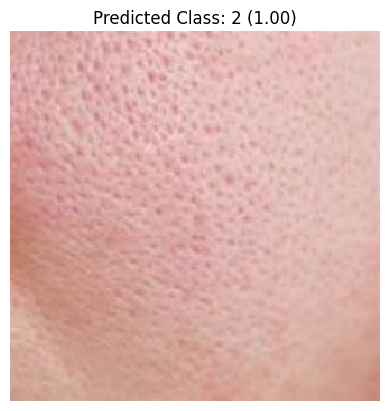

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving Pas Foto Terbaru.jpg to Pas Foto Terbaru (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


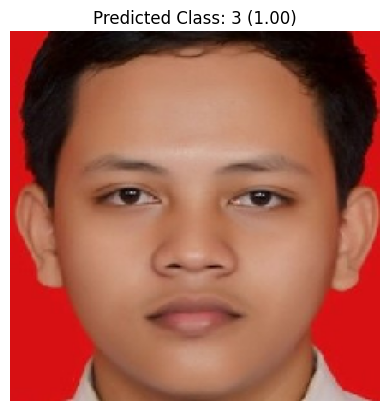

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving keriputt.jpg to keriputt (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


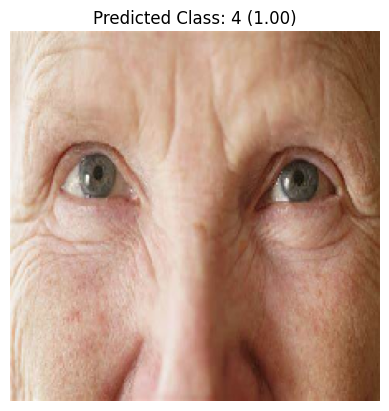

Apakah Anda ingin memprediksi gambar lain? (y/n): n


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict():
    while True:
        uploaded = files.upload()

        for filename in uploaded.keys():
            img_path = filename
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)
            confidence = predictions[0][predicted_class[0]]

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted Class: {predicted_class[0]} ({confidence:.2f})")
            plt.show()

        more_images = input("Apakah Anda ingin memprediksi gambar lain? (y/n): ")
        if more_images.lower() != 'y':
            break

upload_and_predict()

As seen in the classification results above, the classes are correctly predicted and the model has a satisfactory confidence level.

Once the tests for each class are completed, we can now save the model by running the following code:

In [ ]:
model.save('skin_condition1_model.h5')
files.download('skin_condition1_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally! We have completed all the steps and successfully built a model for skin condition classification, saved in h5 format!